<a href="https://colab.research.google.com/github/apmoore1/pea_classification/blob/master/notebooks/PEA_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
! pip install git+git://github.com/apmoore1/pea_classification.git@master#egg=pea_classification
! pip install seaborn

In [0]:
from pathlib import Path

#import altair as alt
#alt.renderers.enable('colab')
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# Formatting of charts
matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=12)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

import pea_classification

# PEA Data Analysis
Preliminary Earnings Announcements (PEA) dataset ([El-Haj et al. 2016](https://www.aclweb.org/anthology/L16-1287.pdf)) consists of sentences from multiple random PEA documents from British firms. Each sentence is annotated with the following annotations:
1. If the sentence is talking about the performance of the company, this makes the sentence a performance sentence.
2. The sentence contains attribution internally, externally or not at all. Here attribution means whether something within the sentence has been done because of internal or external factors. e.g. This sentence contain internal attribution "our
continuing focus on tight cost control."
3. The overall tone/sentiment of the sentence.

In this analysis we are looking at all three of these annotations.

This notebook is broken down into the following sections:
1. Exploring the dataset -- Mainly describes the annotations in detail, as well as how to automatically load the dataset.
2. Experiments -- Experiments that we have conducted from this dataset, from this we show the data statistics of these different experiments.
3. How to train your own Bag Of Words (BOW) method to apply to these experiments, why you should look further than than just accuracy scores, BOW hyperparameter tuning, and under/over sampling.
4. How to apply a count based word list to these experiments e.g. L&M and generally to new data.
5. How to use pre-trained BOW and word list methods to apply to one of these experiments, as well as new data.

## Exploring the dataset

Before any analysis can be done we must first load the train and test datasets, which is shown below. The dataset is automtically downloaded into a cache directory `~/.pea_directory/` and then loaded into train and test datasets.

The `~` in the file path is shorthand for your home directory.
 
### Dataset Labels
We explain the different columns in the dataset and what the labels mean:

In [3]:
train_dataset = pea_classification.dataset_util.train_dataset()
test_dataset = pea_classification.dataset_util.test_dataset()

num_train_samples, num_train_columns = train_dataset.shape
num_test_samples, num_test_columns = test_dataset.shape
total_num_samples = num_train_samples + num_test_samples

train_percentage = (num_train_samples / total_num_samples) * 100
test_percentage = (num_test_samples / total_num_samples) * 100
print(f'Size of train: {train_dataset.shape} ({train_percentage:.2f}%)'
      f'\nSize of test: {test_dataset.shape} ({test_percentage:.2f}%)')

Size of train: (7197, 22) (62.16%)
Size of test: (4382, 22) (37.84%)


We have 7197 and 4382 training and test samples respectively with 22 columns. The majority of these columns which are denoted as `exp*` contain values that will be used to subset and label our data for experiments that we will come to later in the experiment section. The first 3 columns `DocumentID`, `SentenceID`, and `SentmainID` are used to indetify the samples. Finally the 4 main columns of interest are the following:
1. `sentence` -- The sentence text.
2. `senttype` -- Whether the sentence is performance and if it contains an attribution.
3. `perftone` -- The tone/sentiment of the sentence, on the condition that it is a performance sentence.
4. `atttype` -- The attribution type.

Defination of performance -- "The economic outcome of the operating activities during the financial year along with an indication of the
quality of the operation outcome"[ADD Citation]



In [4]:
train_dataset.columns

Index(['DocumentID', 'SentenceID', 'SentmainID', 'sentence', 'senttype',
       'perftone', 'atttype', 'exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6a',
       'exp6b', 'exp7a', 'exp7b', 'exp8', 'exp9', 'exp10a', 'exp10b', 'exp11a',
       'exp11b'],
      dtype='object')

Lets have a look at the different values each of the 4 main columns contain apart from the sentence column:

In [5]:
print('Train dataset columns and associated values')
for column_name in ['atttype', 'perftone', 'senttype']:
  unique_column_values = train_dataset[column_name].unique().tolist()
  unique_column_values = sorted([str(value) for value in unique_column_values])
  print(f'Column name: {column_name}, unique values: {unique_column_values}')

Train dataset columns and associated values
Column name: atttype, unique values: ['BOTH', 'EXT', 'INT', 'UNSURE', 'nan']
Column name: perftone, unique values: ['MIXED', 'NEG', 'NEG_COMP', 'NEU', 'POS', 'POS_COMP']
Column name: senttype, unique values: ['attnonperf', 'attperf', 'nonperfnonatt', 'perfnonatt']


In [6]:
print('Test dataset columns and associated values')
for column_name in ['atttype', 'perftone', 'senttype']:
  unique_column_values = test_dataset[column_name].unique().tolist()
  unique_column_values = sorted([str(value) for value in unique_column_values])
  print(f'Column name: {column_name}, unique values: {unique_column_values}')

Test dataset columns and associated values
Column name: atttype, unique values: ['BOTH', 'EXT', 'INT', 'UNSURE', 'nan']
Column name: perftone, unique values: ['MIXED', 'NEG', 'NEG_COMP', 'NEU', 'NEU_COMP', 'POS', 'POS_COMP']
Column name: senttype, unique values: ['attnonperf', 'attperf', 'nonperfnonatt', 'perfnonatt']


The columns have the following values:
1. Attribution column (atttype):
  * INT -- contains at least one internal attribution.
  * EXT -- contains at least one external attribution.
  * BOTH -- contains both internal and external attribution.
  * UNSURE -- annotators could not decide on the attribution but an attribution does exist.
  * nan -- not applicable e.g. no attribution.
2. Tone/Sentiment column (perftone):
  * POS and POS_COMP -- both positive tone.
  * NEG and NEG_COMP -- both negative tone.
  * MIXED -- contains both positive and negative tone.
  * NEU and NEU_COMP -- neutral tone. (Note: that the test dataset is the only dataset that contains the `NEU_COMP` label)
3. Performance column (senttype):
  * attnonperf -- contains attribution but not a performance sentence.
  * nonperfnonatt -- contains no attribution and is not a performance sentence.
  * perfnonatt -- contains no attribution and is a performance sentence.
  * attperf -- contains attribution and is a performance sentence.

### Sentence Lengths 

Next we tokenise the sentences using the [English Spacy tokeniser](https://spacy.io/). Then using the tokens of each sentence we measure the sentence length based on the number of tokens in the sentence. Looking at the data can help find any potential problematic samples and helps sainty check the dataset before you go any further in modelling of the data.

In [7]:
from pea_classification.dataset_util import spacy_tokenizer
tokeniser = spacy_tokenizer()
# Get the sentence length by splitting the sentence into words using spacy
interesting_columns = ['sentence', 'senttype', 'perftone', 'atttype', 
                       'Sentence Lengths']
train_and_test_df = pd.concat([train_dataset, test_dataset], 0)

sentences = train_and_test_df.loc[:,'sentence'].copy()
sentence_lengths = sentences.apply(lambda x: len(tokeniser(x)))
train_and_test_df['Sentence Lengths'] = sentence_lengths
train_and_test_df.sort_values(by=['Sentence Lengths']).head(7)[interesting_columns]

,sentence,senttype,perftone,atttype,Sentence Lengths
5868,Schools.,nonperfnonatt,POS,NaN,2
7969,Poland .,nonperfnonatt,POS,NaN,2
9039,on last year.,nonperfnonatt,NEG,NaN,4
4426,on last year.,nonperfnonatt,NEG,NaN,4
2526,Growth was wholly organic.,nonperfnonatt,POS,NaN,5
7839,Graham Holden Chief Executive <,nonperfnonatt,POS,NaN,5
938,We continue to reduce costs.,perfnonatt,POS,NaN,6


The shortest sentences generally are not performance sentences which are good as some of them contain no meaning e.g. "Schools.", "Poland .", etc but short sentences can contain both performance sentence and meaningful tone/sentiment e.g. "Meat-free sales decreased 1.9%"

Below shows that some of the sentences can be really long!

In [8]:
train_and_test_df.sort_values(by=['Sentence Lengths']).tail(3)[interesting_columns]

,sentence,senttype,perftone,atttype,Sentence Lengths
11219,Segmental analysis Insurance Services Financia...,nonperfnonatt,POS,NaN,429
2924,The table below sets forth selected financial ...,nonperfnonatt,POS,NaN,435
11436,SALES VOLUMES Year ended 31.12.11 Year ended 3...,nonperfnonatt,POS,NaN,759


Lastly below we show the summary statistics of sentence lengths and we can see that generally sentences are between 20 and 37 words long.

In [9]:
train_and_test_df['Sentence Lengths'].describe()

count    11579.000000
mean        32.321271
std         25.157608
min          2.000000
25%         20.000000
50%         28.000000
75%         37.000000
max        759.000000
Name: Sentence Lengths, dtype: float64

We can also compare the training and test data sentence lengths to see the differences:

In [10]:
test_sent_lengths = train_and_test_df.loc[test_dataset.index]['Sentence Lengths']
test_sent_lengths_stats = test_sent_lengths.describe()
train_sent_lengths = train_and_test_df.loc[train_dataset.index]['Sentence Lengths']
train_sent_lengths_stats = train_sent_lengths.describe()
test_sent_lengths_stats - train_sent_lengths_stats

count   -2815.000000
mean        0.688482
std         2.693455
min         0.000000
25%         1.000000
50%         0.000000
75%         1.000000
max       324.000000
Name: Sentence Lengths, dtype: float64

From the above we can see from the `count` the test dataset is smaller, which we already know. The mean sentence length is slightly longer by `0.68` and the `standard deviation` is larger by `2.8` indicating that the distribution of sentence lengths in the test is more spread out. Lastly the test data has a much larger largest text indiciated by the `max` value of `324`.

We can better visualise these statistics using a historgram:

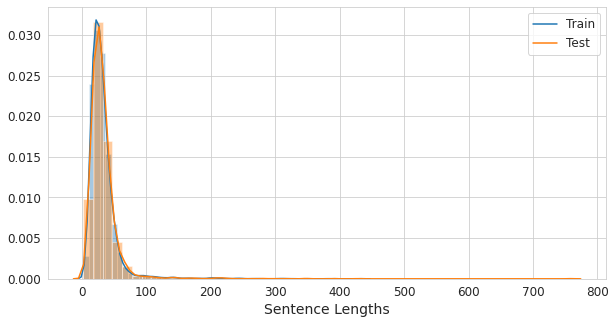

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = sns.distplot(train_sent_lengths, kde_kws={'label': 'Train'},ax=ax)
ax = sns.distplot(test_sent_lengths, kde_kws={'label': 'Test'}, ax=ax)

As we can see the histogram has a very long tail, which is rather informative for the graph and makes it difficult to visulaise. Therefore we are only going to visulaise the sentence lengths up to length 175 to get a better understanding of the distribution between the training and test splits:

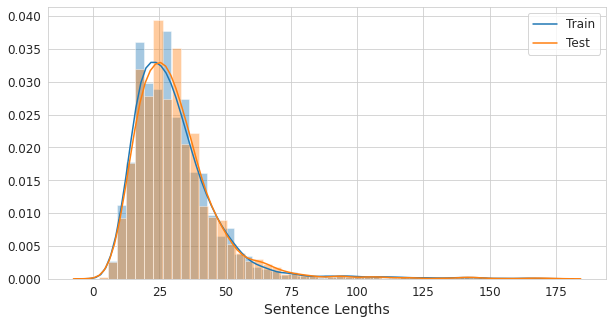

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax = sns.distplot(train_sent_lengths[train_sent_lengths < 176], kde_kws={'label': 'Train'},ax=ax)
ax = sns.distplot(test_sent_lengths[test_sent_lengths < 176], kde_kws={'label': 'Test'}, ax=ax)

From this graph we can better see the two distributions. It can be seen that the setnence lengths between train and test splits do not vary much. Furthermore if you look at the lines (which is a smoothed approximation of the data based on a normal distribution), the two lines are very close to each other indiciating that the setence lengths do not differ much between the splits.

This deep dive into the sentence lengths is to demonstrate a way of visulising some of the data in the datasets.

### Tokenisation

We now move on to creating tokenised sentences in the train and test splits. When exploring the sentence lengths we never actually added the tokenised sentences to the dataset that we are going to use to model. Below we shall tokenise the sentences and then join the tokens back together using whitespace and add them to the dataset.

The reason for joining the tokens back together using whitespace is so that the models in the future only have to perform white space splitting rather than tokenising using Spacy to get the spacy tokens. This is more of an efficency saving.

In [0]:
train_dataset['tokeniser_sentences'] = train_dataset.loc[:, 'sentence'].apply(lambda x: ' '.join(tokeniser(x)))
test_dataset['tokeniser_sentences'] = test_dataset.loc[:, 'sentence'].apply(lambda x: ' '.join(tokeniser(x)))

Below are example of the tokenised sentences:

In [14]:
train_dataset['tokeniser_sentences'].head(10)

0    Good performances across most of the Group mea...
1    Strong overall growth in the earnings of our P...
2    Our balance sheet remains strong with net debt...
3    These have increased the effectiveness of our ...
4    Earnings growth in our Private Equity portfoli...
5    However , there have been elements of this por...
6    Together , they have helped to broaden the exp...
7    Lower operating costs and increased assets und...
8    I have also been determined to put 3i back on ...
9    Performance Our total return for the year to 3...
Name: tokeniser_sentences, dtype: object

And the original sentences, some of the main differences between the two are the commas in sentence 5 and 6. More differences can be seen if you look at the whole sentences rather than the extracts shown here.

In [15]:
train_dataset['sentence'].head(10)

0    Good performances across most of the Group mea...
1    Strong overall growth in the earnings of our P...
2    Our balance sheet remains strong with net debt...
3    These have increased the effectiveness of our ...
4    Earnings growth in our Private Equity portfoli...
5    However, there have been elements of this port...
6    Together, they have helped to broaden the expe...
7    Lower operating costs and increased assets und...
8    I have also been determined to put 3i back on ...
9    Performance Our total return for the year to 3...
Name: sentence, dtype: object

And below we can see the dataset now has a new column `tokeniser_sentences`

In [16]:
test_dataset.columns

Index(['DocumentID', 'SentenceID', 'SentmainID', 'sentence', 'senttype',
       'perftone', 'atttype', 'exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6a',
       'exp6b', 'exp7a', 'exp7b', 'exp8', 'exp9', 'exp10a', 'exp10b', 'exp11a',
       'exp11b', 'tokeniser_sentences'],
      dtype='object')

## Experiments
Now that we have given a quick overview of the dataset we are going to move into the different experiments we are going to conduct. These experiments can be split into 3 main sections identifying: 
1. Tone/Sentiment
2. Attribution
3. Performance.

NOTE: Each of the experiments we perform here relate to the `exp*` columns within the data. This does not mean you cannot create your own experiments such as predicting Positive, Neutral, and Negative sentiment/tone. All the experiments conducted here are binary classification problems.

### Tone/Sentiment
1. Can we predict positive or negative sentiment given the sentence is a performance sentence? (labels 1=positive, 2=negative, column name = `exp1`)
2. Same as `exp1` but conditioned on the sentence coming from a `no attribution` sentence. (labels 1=positive, 2=negative, column name = `exp2`)

### Attribution
1. Can we predict if the sentence is an attribution sentence? (labels 1=attribution, 2=no attribution, column name = `exp3`)
2. Same as `exp3` but conditioned on the sentence being a `performance` sentence. (labels 1=attribution, 2=no-attribution, column name = `exp4`)
3. Predict if the sentence is an `Internal` or `External` sentence conditioned on the sentence being an `attribution` sentence. (labels 1=Internal, 2=External, column name =`exp5`)
4. Can we predict if the sentence is an `attribution` sentence if the `attribution` sentences are of all `Internal` type. (lables 1=attribution, 2=no-attribution, column name =`exp6a`)
5. Can we predict if the sentence is an `attribution` sentence if the `attribution` sentences are of all `External` type. (lables 1=attribution, 2=no-attribution, column name =`exp6b`)

Note: That column names `exp7a` and `exp7b` are not used because they are the same experiment as `exp6a` and `exp6b` respectively.

### Performance
1. Can we predict performance from non-performance sentences? (labels 1=performance, 2=non-performance, column name=`exp8`)
2. Same as `exp8` but the sentences do not contain any attribution. (labels 1=performance, 2=non-performance, column name=`exp9`)
3. Can we predict performance from non-performance given that all of the performance sentence are `positive` in tone/sentiment? (labels 1=performance, 2=non-performance, column name=`exp10a`)
4. Can we predict performance from non-performance given that all of the performance sentence are `negative` in tone/sentiment? (labels 1=performance, 2=non-performance, column name=`exp10b`)

Note: That column names `exp11a` and `exp11b` are not used because they are the same experiment as `exp10a` and `exp10b` respectively.

As you can see all of these experiments are binary classification tasks. 

### Data Distribution 

One of the main problems with all of these experiments is the data distribution. In alot of these experiments the data is highly skewed to one of the classes. Below we show this, where by the Y-axis represents the percentage of samples that are in the associated class for each experiment:

#### Training split

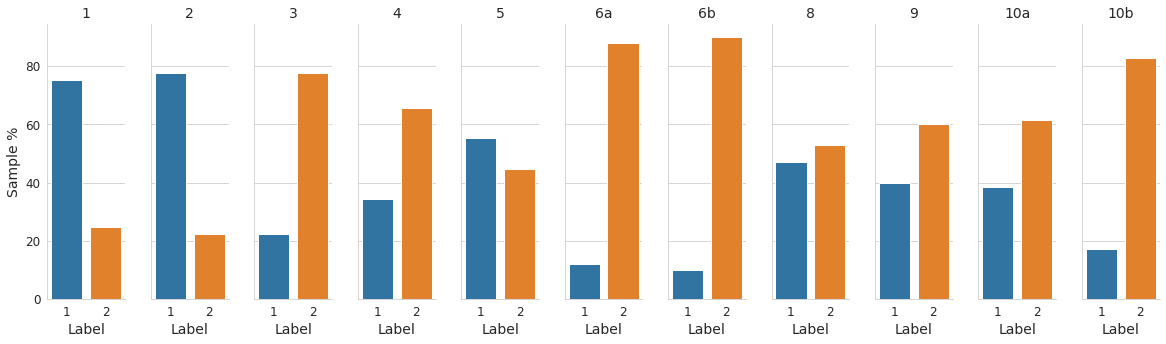

In [78]:
experiment_ids = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6a', 'exp6b', 
                  'exp8', 'exp9', 'exp10a', 'exp10b']
df_experiment_ids = []
# this is either one or two
label_names = []
# the number of times the label occurs
label_counts = []
# the percentage label occurs for the experiment
label_percentages = []
# Whether it is the training or test split
train_or_test = []
for experiment_id in experiment_ids:
  for data_name, data in [('Train', train_dataset), ('Test', test_dataset)]:
    # Only using this function as it is the esiest way to get experiment specific 
    # data
    _, data_labels = pea_classification.dataset_util.get_experiment_data(data, experiment_id, 'sentence')
    possible_data_labels = set([1,2])
    assert possible_data_labels == set(np.unique(data_labels))
    total_number_labels = data_labels.shape[0]
    for label_value in [1, 2]:
      label_count = (data_labels==label_value).sum()
      assert label_count > 0
      df_experiment_ids.append(re.search(r'\d+.*', experiment_id)[0])
      label_names.append(str(label_value))
      label_counts.append(label_count)
      label_percentages.append(100 * (label_count / total_number_labels))
      train_or_test.append(data_name)
dataset_df = pd.DataFrame({'Exp ID': df_experiment_ids, 
                           'Label': label_names, 
                           'Samples': label_counts,
                           'Sample %': label_percentages, 
                           'Dataset': train_or_test})

train_sample_df = dataset_df[dataset_df['Dataset']=='Train']
train_sample_ax = sns.catplot(data=train_sample_df, col='Exp ID', x='Label', 
                              y='Sample %', kind='bar', height=5, aspect=.3)
_ = train_sample_ax.set_titles("{col_name}")

#### Test split

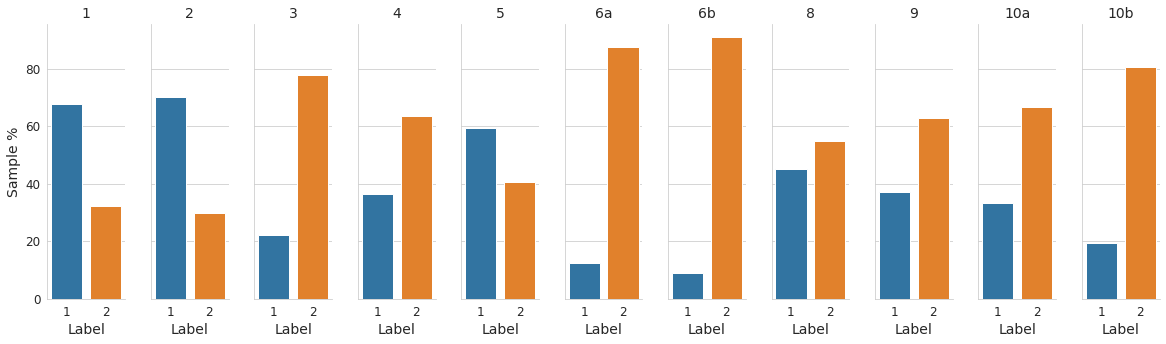

In [79]:
test_sample_df = dataset_df[dataset_df['Dataset']=='Test']
test_sample_ax = sns.catplot(data=test_sample_df, col='Exp ID', x='Label', 
                             y='Sample %', kind='bar', height=5, aspect=.3)
_ = test_sample_ax.set_titles("{col_name}")

From both of the splits we can see that experiment `6a` and `6b` have the worse data balance where by the 2nd class (no attribution) is the largest class by far.

#### Difference between the two splits

Below we show what the data distribution difference between the test and the training split. This is to see if there are any major differences in class label sizes between the splits. From what can be seen below this is not the case.

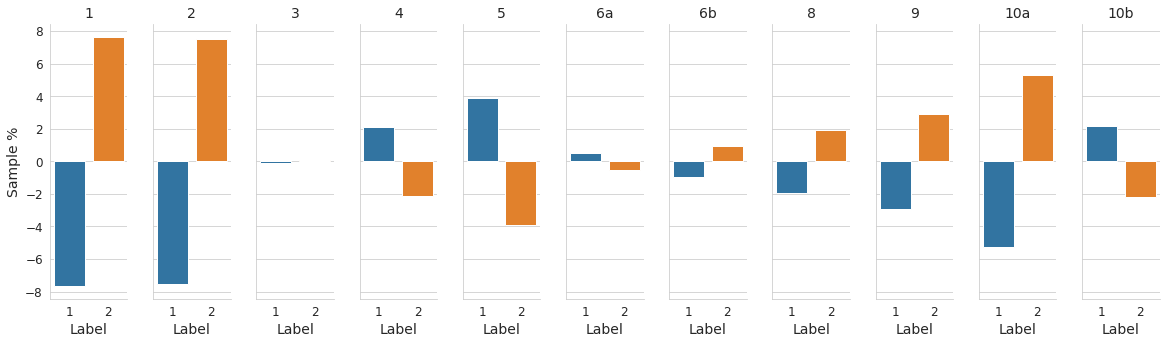

In [80]:
test_sample_index_df = test_sample_df.set_index(['Exp ID', 'Label'])
train_sample_index_df = train_sample_df.set_index(['Exp ID', 'Label'])
diff_sample_df = (test_sample_index_df['Sample %'] - 
                  train_sample_index_df['Sample %']).reset_index()
diff_sample_ax = sns.catplot(data=diff_sample_df, col='Exp ID', x='Label', 
                             y='Sample %', kind='bar', height=5, aspect=.3)
_ = diff_sample_ax.set_titles("{col_name}")

#### Example of showing the raw sample count

If you want to see the number of samples in each class for each experiment below is an example of how to visualise this for the training split, of which in comparison to the percentages it shows which experiment contains more or less data/samples.

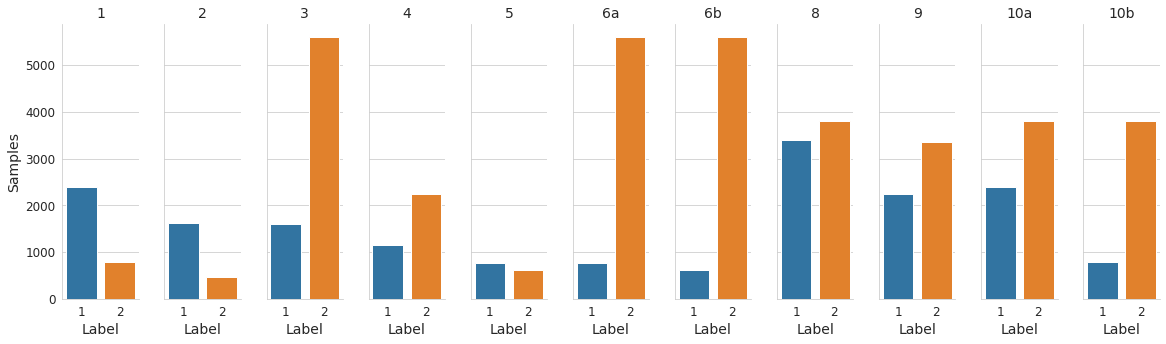

In [81]:
train_sample_ax = sns.catplot(data=train_sample_df, col='Exp ID', x='Label', 
                              y='Samples', kind='bar', height=5, aspect=.3)
_ = train_sample_ax.set_titles("{col_name}")

Due to the majority of the experiments containing large data in-balances, we will perform each experiment **3** times:
1. `un_balanced` -- using the original training data.
2. `over_sampled` -- randomly generating more training data for the label with the fewest examples from the exisiting dataset until we have an equal amount of training examples for both labels.
3. `under_sampled` -- same as over_sampled but here we randomly remove data from the label with the most examples until we have an equal amount of training examples for both labels.

## Training a Bag Of Words (BOW) model

As we have now described the experiments that can be conducted, here we are going to describe the BOW models we used in all of these experiments and briefly how to apply them (for the full script on how we trained all models on all experiments see this python script and the end part of the README.).

The BOW models had the following 6 general steps from raw text to a classification:
1. Tokenise the text using [Spacy](https://spacy.io/) English tokeniser and then lower case them. NOTE: all of the models here assume the text has been pre-tokenised and all the classifier pipeline has to do is split on whitespace.
2. Extract Bag Of Word features, either uni-grams or uni-grams and bi-grams, from the tokens of the text.
3. Put the BOW features through a [TF-IDF transformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer).
4. Feature selection using [chi-squared statistic](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html).
5. Scaling the features.
6. The features are then input to a classifier e.g. Random Forest.

The classifiers we have used are the following:
1. [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) (MNB)
2. [Complement Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB) (CNB)
3. [Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) (RF)
4. [Linear Support Vector Machine (SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
5. [Multi-layer Perceptron (MLP) Neural Network (NN)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Below we show an example of how to train a Linear SVM using all of the 6 steps stated above using only the data provided therefore no under or over sampling is applied here:


In [87]:
from pea_classification.classifiers import classifier_pipeline, LinearSVC
bow_pipeline = classifier_pipeline(oversample=False, undersample=False, 
                                   classifier=LinearSVC())
bow_pipeline.steps

[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 2), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<method 'split' of 'str' objects>, vocabulary=None)),
 ('tfidf',
  TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False, use_idf=True)),
 ('feature_selector',
  SelectKBest(k=10, score_func=<function chi2 at 0x7f7bc633b1e0>)),
 ('scale', MaxAbsScaler(copy=True)),
 ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
            intercept_scaling=1, loss='squared_hinge', max_iter=1000,
            multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
            verbose=0))]

As shown above we have just created a pipeline that has all of the 6 steps stated above:
1. First it uses a [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) to tokenise and then extract out **uni-gram and bi-gram features**
2. Then it puts it through a [TF-IDF Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) to get the TF-IDF transformed features.
3. We select the top *k=10* features using [chi-squared statistic](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html).
4. Then scale these features using [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html), which ensures that the features are between 0-1 for each feature. This is ensured by dividing each feature by its features largest value.
5. Then we use a [Linear SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) to classify.

NOTE: The [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) we use here is a bit custom in the sense that it only lower cases the words and splits on whitespace, but it does not perform tokenisation using Spacy. To get the Spacy tokenisation into this process we first tokenise the sentences and then re-join the sentences using whitespace.

Now that we have our pipeline that performs all of these 6 steps we need to train the classifier, to do so we have chosen the attribution/no-attribution experiment of `exp3`. First we get our training data:

In [88]:
exp1_label_mapper = {1: 'Attribution', 2: 'No-Attribution'}
train_sentences, train_labels = pea_classification.dataset_util.get_experiment_data(train_dataset, 'exp3', 'sentence')
print(f'Sentence 1: {train_sentences[0]}')
print(f'Label: {train_labels[0]}, {exp1_label_mapper[train_labels[0]]}')

Sentence 1: Good performances across most of the Group meant that we were able to deliver a total return of 10.6%, despite a significant value reduction in one of our largest investments.
Label: 2, No-Attribution


As we can see the sentence is contains no attribution but it has not been tokenised by Spacy yet which is what we will do now:

In [89]:
from pea_classification.dataset_util import spacy_tokenizer
tokeniser = spacy_tokenizer()

train_tok_sentences = [' '.join(tokeniser(sentence)) for sentence in train_sentences]
print(f'Tokenised sentence 1:\n{train_tok_sentences[0]}')

Tokenised sentence 1:
Good performances across most of the Group meant that we were able to deliver a total return of 10.6 % , despite a significant value reduction in one of our largest investments .


As we can see by comparing before and after the sentence is tokenised and has been re-joined to create a whole sentence but with the tokens easily identifiable via whitespace. Good example to see that tokenisation has been performed is around commas e.g. `return of 10.6 % , despite` in the sentence above.

Now that the sentence have been tokenised and re-joined we can train the classifier using the 6 step pipeline above:

In [0]:
%%capture
bow_pipeline.fit(train_tok_sentences, train_labels)

We have now trained our classifier lets see it's performance on the test set using accuracy as the metric:

In [91]:
test_sentences, test_labels = pea_classification.dataset_util.get_experiment_data(test_dataset, 'exp3', 'sentence')
test_tok_sentences = [' '.join(tokeniser(sentence)) for sentence in test_sentences]
round(bow_pipeline.score(test_tok_sentences, test_labels) * 100, 2)

79.51

### Looking at more than the accuracy scores, individual label F1 scores
We can see that we get an Accuracy of 79.51%. However we can see that from the data distribution graphs above that the `exp3` data is very in-balanced. Lets see how well it performs using F1 metrics for both of the labels:

In [92]:
from pea_classification.classifier_util import predict_score
more_test_scores = predict_score(bow_pipeline, test_tok_sentences, test_labels)
# converting scores to percentages and rounding to 2 decimal places
more_test_scores = {score_name: round(score_value * 100, 2) 
                    for score_name, score_value in more_test_scores.items()}
print(f"Accuracy {more_test_scores['Accuracy']}")
print(f"F1 attribution label {more_test_scores['F1 Class 1']}")
print(f"F1 no-attribution label {more_test_scores['F1 Class 2']}")

Accuracy 79.51
F1 attribution label 26.87
F1 no-attribution label 88.08


As we can see from above the classifier may have a really good accuracy score, but it is actually really bad at predicting the attribution class (class 1), which is the least represented class. In practice we want a classifier that can predict both classes really well not just the one.

A better overall metric would therefore be the `Macro F1` score which takes the average of the two F1 scores from above:

In [93]:
print(f"Macro F1 {more_test_scores['Macro F1']}")

Macro F1 57.48


### Custom classifiers
We have now introduced you to performing one experiment with one classifier but we can easily now compare two classifier while keeping the features/pre-processing the same.

We have already stated the 5 [SKLearn](https://scikit-learn.org/stable/index.html) classifiers that we have used in all of experiments above, all of which we have used with default settings but for reproducability reasons can be accessed within our python code [here](https://github.com/apmoore1/pea_classification/blob/master/pea_classification/classifiers.py). 

However you might want to use a custom or another different standard SKLearn classifier thus this is what we shall show you how to do now using the same experiment as before:

In [94]:
import math
from sklearn.neighbors import KNeighborsClassifier

# This has come from the suggestion in this blog post:
# https://towardsdatascience.com/a-simple-introduction-to-k-nearest-neighbors-algorithm-b3519ed98e
# but you can choose any interger value for number of neighbors used
number_data_points = len(train_sentences)
n_neighbors = int(math.sqrt(number_data_points))
print(f'Number of neighbors used {n_neighbors}')

custom_clf_pipeline = classifier_pipeline(oversample=False, undersample=False, 
                                          classifier=KNeighborsClassifier(n_neighbors=n_neighbors))
custom_clf_pipeline.fit(train_tok_sentences, train_labels)
custom_test_scores = predict_score(custom_clf_pipeline, test_tok_sentences, test_labels)

custom_test_scores = {score_name: round(score_value * 100, 2) 
                      for score_name, score_value in custom_test_scores.items()}
print(f"Accuracy {custom_test_scores['Accuracy']}")
print(f"Macro F1 {custom_test_scores['Macro F1']}")
print(f"F1 attribution label {custom_test_scores['F1 Class 1']}")
print(f"F1 no-attribution label {custom_test_scores['F1 Class 2']}")

Number of neighbors used 84
Accuracy 79.16
Macro F1 61.61
F1 attribution label 35.66
F1 no-attribution label 87.57


Above we have trained and tested a custom classifier that has come from the SKLearn library, which is a [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) where we have set the number of neighbors to be 84.

If we only look at the Accuracy metric the linear SVM is better (79.51 compared to 79.16). However the KNN performs much better on the Attribution label as shown by the F1 score of 35.66 compared to the SVM's 26.87. Further it has a better Macro F1 score. This shows to some degree why you may prefer the KNN classifier over the Linear SVM as it can perform much better on the least represented class while performing almost on par with the most represented class. **More importantly** this shows why looking at more than one metric is important.

### Finding the best features and classifier parameters (hyperparameter tuning)

As stated from the custom classifier we to some extent arbtarily chose the number of neighbors to be 84 but in fact this might not be the best number of neighbors. This problem also applies to other parts of out 6 step pipeline such as:
1. Whether to use uni-grams, bi-grams or uni-grams and bi-grams. Or other combination of n-grams.
2. *k* in the number of top feature to select when using the chi-squared statistic. In our previous experiment here we used 10 which is probably not large enough as this would mean we only show the classifier 10 unique words word counts which is not many when we have 13,654 unique words in the training set (see code below).
3. Currently we scale the features which is generally a good thing but for some classifier this might not be. Therefore testing if scaling helps might be a good idea.

In [95]:
number_unique_words_in_train = len(set([word for sentence in train_tok_sentences for word in sentence.split()]))
print('Number of unique words in the training set for '
      f'Experiment 3: {number_unique_words_in_train}')

Number of unique words in the training set for Experiment 3: 13654


In our own experiments we searched for the best parameters from the following search space:
1. Using uni-grams only or using uni-grams and bi-grams (2 options)
2. *k* from the feature selection can be any random integer from 100 to 1500 (1400 different options). We could have choosen a larger range but we believe this range to be larger enough.
3. Whether to use MaxAbsScalar or not (2 options).

Therefore we have 2 * 2 * 1400 = 5600 different options.

To find which of these options is best without overfitting to the test dataset we use 10-fold Cross Validation (CV) for each option which basically splits the dataset up into 10 different train and test splits and runs the pipeline 10 times on these splits and then reports the average of these 10 results.

As 5600 options is far too many options we perform [Random Search CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV) which selects at random one these 5600 options and runs the 10 fold CV, this is repeated *n* times where *n* defines our budget which in our case and the one shown below is 40 (40 again is an arbitrary number).

These 5600 parameters are just feature parameters that we can tune, there are more! We can tune the classifier parameters such as the number of neighbors in the KNN. In out experiments we tune the following classifier parameters for the associated classifiers:
1. MNB
  * label/class prior: Whether or not learn the class prior or use a uniform prior. (2 options)
2. CMB
  * label/class prior: Whether or not learn the class prior or use a uniform prior. (2 options)
  * weight normlisation: Whether or not to normalise the weights based on the document length. (2 options)
3. RF
  * Number of trees. This is chosen from a random integer between 10 and 50. (40 options)
4. Linear SVM
  * C Penalty: One of the following 5 options [10, 1, 0.1, 0.001, 0.0001]
5. MLP NN:
  * The NN size and dimension: One of the following 4 options: [(50,), (100, 50), (50, 25), (75, 35)]. Where (50,) means one layer NN with the first layer of size 50 and (100, 50) means two layer NN with the first layer of size 100 and the second 50.

As can be seen depending on the classifier used in our experiments affects our search space size e.g. MNB search space is 5600 * 2 = 12200 where as the RF = 5600 * 40 = 224000. Hence this is the reason why a budget is needed so that each classifier/pipeline is fairly compared.

Below how the Random Search CV can be implemented with a budget of 40 given the search space defined above for the Linear SVM on our current experiment (`exp3`).

Note we are using a helper function `classifier_grid_search` which will only search the search spaces we have defined above for the classifiers and pipeline we stated above and will not work with custom classifiers like the KNN used earlier.

In [96]:
from pea_classification.classifier_util import classifier_grid_search

clf_grid_search = classifier_grid_search(train_tok_sentences, train_labels, 
                                         classifier_name='svm_classifier', 
                                         budget=40, oversample=False, 
                                         undersample=False, save_results=None, 
                                         save_model=None)
best_mean_acc, best_acc_sd, best_params, tuned_svm_clf = clf_grid_search
best_mean_acc = round(best_mean_acc * 100, 2)
best_acc_sd = round(best_acc_sd * 100, 2)
print('The best parameters mean accuracy across the 10 CV folds: '
      f'{best_mean_acc} and Standard Deviation: {best_acc_sd}')
print('Best parameters found given the budget of 40:')
for parameter_name, parameter_value in best_params.items():
  print(f'Parameter name and value: {parameter_name} {parameter_value}')

The best parameters mean accuracy across the 10 CV folds: 80.46 and Standard Deviation: 2.69
Best parameters found given the budget of 40:
Parameter name and value: clf__C 0.001
Parameter name and value: feature_selector__k 584
Parameter name and value: scale None
Parameter name and value: vect__ngram_range (1, 1)


As we can see the best pipeline parameters are using uni-grams, top 584 features from the feature selector, not scaling and the classifier have a C penalty of 0.001.

Across the 10 folds it got a mean accuracy score of 80.46% with 2.69 standard deviation. Lets see how this pipeline does on the test set:

In [97]:
tuned_test_scores = predict_score(tuned_svm_clf, test_tok_sentences, test_labels)
tuned_test_scores = {score_name: round(score_value * 100, 2) 
                     for score_name, score_value in tuned_test_scores.items()}
print(f"Accuracy {tuned_test_scores['Accuracy']}")
print(f"Macro F1 {tuned_test_scores['Macro F1']}")
print(f"F1 attribution label {tuned_test_scores['F1 Class 1']}")
print(f"F1 no-attribution label {tuned_test_scores['F1 Class 2']}")

Accuracy 81.95
Macro F1 68.41
F1 attribution label 47.72
F1 no-attribution label 89.09


As we can see this massively outperforms the original Linear SVM that uses the non-tuned parameters. Original Linear SVM got 79.51, 61.61, 26.87, 88.08 of which we can see that the tuned made massive gains in performing better on the smallest label set, label 1 which is great news. **This shows why it is so important to hyperparameter tune**. Further the Linear SVM now outperforms the KNN on all metrics, but the KNN has not be tuned so the comparison is unfair.

### Over and under sampling
Now that we have shown the importance og hyperparameter tuning next we want to show why under and over sampling is important. This is actually quite easy, it is just another step in the pipeline between, the feature selection step and the scaling step.

NOTE: For those interested the over and under sampling was done using the [imbalanced package](https://imbalanced-learn.readthedocs.io/en/stable/index.html).

Below we show the new pipeline for the original Linear SVM but with over sampling:

In [98]:
bow_over_pipeline = classifier_pipeline(oversample=True, undersample=False, 
                                        classifier=LinearSVC())
bow_over_pipeline.steps

[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 2), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<method 'split' of 'str' objects>, vocabulary=None)),
 ('tfidf',
  TfidfTransformer(norm=None, smooth_idf=True, sublinear_tf=False, use_idf=True)),
 ('feature_selector',
  SelectKBest(k=10, score_func=<function chi2 at 0x7f7bc633b1e0>)),
 ('sampler',
  RandomOverSampler(random_state=42, ratio=None, return_indices=False,
                    sampling_strategy='auto')),
 ('scale', MaxAbsScaler(copy=True)),
 ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
            intercept_scaling=1, loss='squared_hinge', max_iter=1000,
            multi_class='ovr', pena

As we can see above we now have a `sampler` step.

Lets see how this performs once trained and tested on the same `exp3` dataset:

In [99]:
bow_over_pipeline.fit(train_tok_sentences, train_labels)
from pea_classification.classifier_util import predict_score
over_test_scores = predict_score(bow_over_pipeline, test_tok_sentences, test_labels)
over_test_scores = {score_name: round(score_value * 100, 2) 
                    for score_name, score_value in over_test_scores.items()}
print(f"Accuracy {over_test_scores['Accuracy']}")
print(f"Macro F1 {over_test_scores['Macro F1']}")
print(f"F1 attribution label {over_test_scores['F1 Class 1']}")
print(f"F1 no-attribution label {over_test_scores['F1 Class 2']}")

Accuracy 78.0
Macro F1 64.92
F1 attribution label 43.49
F1 no-attribution label 86.34


We can see that the Accuracy is worse than not oversampling (79.51). However the F1 score for the samllest label is much better (26.87), where as the F1 for the most representative label is marginally worse (88.08), but overall the Macro F1 has gone up (61.61). This again shows how skewed the results can look when only looking at the accuracy metric. Even though we have not beaten the original Linear SVM on accuracy we have on Macro F1 which we think shows the merits of over sampling.

Lets have a look at the scores if the over sampling was also hyperparameter tuned:

In [100]:
clf_over_grid_search = classifier_grid_search(train_tok_sentences, train_labels, 
                                              classifier_name='svm_classifier', 
                                              budget=40, save_results=None, 
                                              save_model=None, oversample=True, 
                                              undersample=False)
best_over_mean_acc, best_over_acc_sd, best_over_params, tuned_over_svm_clf = clf_over_grid_search
best_over_mean_acc = round(best_over_mean_acc * 100, 2)
best_over_acc_sd = round(best_over_acc_sd * 100, 2)
print('The best parameters mean accuracy across the 10 CV folds: '
      f'{best_over_mean_acc} and Standard Deviation: {best_over_acc_sd}')
print('Best parameters found given the budget of 40:')
for parameter_name, parameter_value in best_over_params.items():
  print(f'Parameter name and value: {parameter_name} {parameter_value}')
tuned_over_test_scores = predict_score(tuned_over_svm_clf, test_tok_sentences, test_labels)
tuned_over_test_scores = {score_name: round(score_value * 100, 2) 
                          for score_name, score_value in tuned_over_test_scores.items()}
print(f"Accuracy {tuned_over_test_scores['Accuracy']}")
print(f"Macro F1 {tuned_over_test_scores['Macro F1']}")
print(f"F1 attribution label {tuned_over_test_scores['F1 Class 1']}")
print(f"F1 no-attribution label {tuned_over_test_scores['F1 Class 2']}")

The best parameters mean accuracy across the 10 CV folds: 78.77 and Standard Deviation: 3.18
Best parameters found given the budget of 40:
Parameter name and value: clf__C 0.1
Parameter name and value: feature_selector__k 1432
Parameter name and value: scale MaxAbsScaler(copy=True)
Parameter name and value: vect__ngram_range (1, 2)
Accuracy 80.19
Macro F1 72.19
F1 attribution label 57.28
F1 no-attribution label 87.11


Again hyperparameter tuning improves scores! However compared to the un-balanced (non over sampled) tuned Linear SVM it performs worse on the accuracy metric (81.95) and the F1 score on the majority class (89.09). **HOWEVER** it is much better on the smaller class once again (47.72) and a lot better on the Macro F1 score (68.41). **This shows the random over sampling does help when it comes to un-balanced datasets.**

NOTE: To perform under sampling instead of over sampling set the `oversample` argument to `False` and the `undersample` to `True`.

Further if you want to save any of the tuned models or save the results to a csv file, use the `save_model` and `save_results` arguments respectively within the `classifier_grid_search` function.

## Word list approaches

In this python package we have 8 different word lists of which these lists can be goruped into the experiments that they can be applied to:

1. Tone/Sentiment lists (Experiments: `exp1`, `exp2`, `exp10a`, `exp10b`)
  * [Loughran & McDonald (L&M)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2504147)
  * [Henry 2008 (HEN_08)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=933100)
  * [Henry 2006 (HEN_06)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=958749)
2. Attribution detection (Experiments: `exp3`, `exp4`, `exp6a`, `exp6b`)
  * [Zhang and Aerts 2015 (ZA_2015)](http://dx.doi.org/10.1080/00014788.2015.1048771)
  * [Dikoli et al. 2016 (Dikoli_2016)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2131476)
  * Martin Walker All (MW_ALL)
  * Martin Walker 50 (MW_50)
3. Attribution type detection e.g. distinugshing between Internal and External attribution (Experiment: `exp5`):
  * Martin Walker Attribution Type (MW_TYPE)

As you can see we do not have a word list for the performance sentences. All of the Martin Walker word lists are word lists that [Prof. Martin Walker](https://www.research.manchester.ac.uk/portal/martin.walker.html) created.

### Loading the word lists
Below we show for each these word lists how they can be automatically loaded into a Python List.

There are a few things to know before loading these word lists:
1. The word lists are automatically downloaded into the cache directory `~/.pea_directory/`
2. Each word in the word list will be lower cased and all word lists are expanded based American to British English word matching e.g. if the word list has an American spelling e.g. `favored` then the British version will be added to the list `favoured` this also happens vice versa. For theose interested the dictionary mapping US to GB words can be found via this code snippet `pea_classification.word_list_util.US2UK`
3. Some of the word lists have multiple lists which will be explained below.

Below we show an example of how to load a word list specifically the Loughran and McDonald positive and negative lists:

In [101]:
from pea_classification.word_list_util import download_and_read_word_list
lm_pos = download_and_read_word_list('L&M pos')
lm_neg = download_and_read_word_list('L&M neg')
print(f'Length of the positive and negative lists: {len(lm_pos)}, '
      f'{len(lm_neg)}')
print(f'5 words from the positive list: {lm_pos[:5]}')
print(f'5 words from the negative list: {lm_neg[:5]}')

Length of the positive and negative lists: 370, 2397
5 words from the positive list: ['gains', 'stabilise', 'winner', 'distinctiveness', 'progressing']
5 words from the negative list: ['disaffiliation', 'crucial', 'overruns', 'breaking', 'redefaulted']


#### Loading sentiment/tone word lists
Each one of the three lists have two sub lists each, a positive and a negative list, below we show how to load each one and the lengths of each list:

In [102]:
tone_word_lists = ['L&M pos', 'L&M neg', 'HEN 08 pos', 'HEN 08 neg', 
                   'HEN 06 pos', 'HEN 06 neg']
for tone_word_list in tone_word_lists:
  load_word_list = download_and_read_word_list(tone_word_list)
  print(f'{tone_word_list}, length: {len(load_word_list)}')

L&M pos, length: 370
L&M neg, length: 2397
HEN 08 pos, length: 104
HEN 08 neg, length: 86
HEN 06 pos, length: 117
HEN 06 neg, length: 94


#### Loading attribution detection lists
Each of the 4 word lists only contain one word list thus no sub-lists. Unlike the tone lists where you could perhaps classify a sentence as positive if it contains more positive words than negative, these lists are used in the manner that if any word in a sentence is within one of these lists then that sentence is classified as a sentence that contains attribution.

In [103]:
attribution_word_lists = ['Dikoli_2016', 'ZA_2015', 'MW_ALL', 'MW_50']
for attribution_word_list in attribution_word_lists:
  load_word_list = download_and_read_word_list(attribution_word_list)
  print(f'{attribution_word_list}, length: {len(load_word_list)}')

Dikoli_2016, length: 139
ZA_2015, length: 108
MW_ALL, length: 256
MW_50, length: 50


#### Loading the attribution type list
`MW_TYPE` list contains two sub lists 1. Internal and 2. External attribution lists. Similar in method to the tone lists these lists can be used to classify sentences into Internal or External attribution sentences.

In [104]:
load_word_list = download_and_read_word_list('MW TYPE INT')
print(f'MW TYPE INT, length: {len(load_word_list)}')
load_word_list = download_and_read_word_list('MW TYPE EXT')
print(f'MW TYPE EXT, length: {len(load_word_list)}')

MW TYPE INT, length: 396
MW TYPE EXT, length: 445


### Classifying with the word lists

As suggested in the loading section these lists can be used to classify sentence. To do so we have created a custom SKLearn Estimator that classify sentences based on the word list that is given. The classification rules are different depending on the word list used thus below we state how the classification is done based on the type of the word list:

1. Tone/Sentiment lists -- classification rule: Frequency of Positive words is greater than Negative words then Positive else Negative. Ties are assigned to the negative class, this also applied for `exp10a` where if it is a positive sentence then it is also a performance sentence. For `exp10b` we flip it around where if the number of negative words is greater than positive then it is a performance sentence else not a performance sentence.
2. Attribution detection lists -- classification rule: If a word in the sentence is within the attribution list then it is classified as an attribution else no attribution.
3. Attribution type -- classification rule: Frequency of Internal words is greater than External words then Internal else External. Ties are assigned to the External class.

Below we show how to load the **HEN_08** word list and classify for the `exp10a` experiment:

In [105]:
from pea_classification.classifiers import WordListClassifier
from pea_classification.classifier_util import predict_score

exp10a_train_data = pea_classification.dataset_util.get_experiment_data(train_dataset, 'exp10a', 'sentence')
exp10a_test_data = pea_classification.dataset_util.get_experiment_data(test_dataset, 'exp10a', 'sentence')
train_exp10a_sentences, train_exp10a_labels = exp10a_train_data
test_exp10a_sentences, test_exp10a_labels = exp10a_test_data

hen_08_exp10a = WordListClassifier('HEN_08', n_jobs=None)
hen_08_exp10a.fit(train_exp10a_sentences)

test_exp10a_scores = predict_score(hen_08_exp10a, test_exp10a_sentences, test_exp10a_labels)
test_exp10a_scores = {score_name: round(score_value * 100, 2) 
                      for score_name, score_value in test_exp10a_scores.items()}
print(f"Accuracy {test_exp10a_scores['Accuracy']}")
print(f"Macro F1 {test_exp10a_scores['Macro F1']}")
print(f"F1 attribution label {test_exp10a_scores['F1 Class 1']}")
print(f"F1 no-attribution label {test_exp10a_scores['F1 Class 2']}")

Accuracy 62.93
Macro F1 62.42
F1 attribution label 58.02
F1 no-attribution label 66.82


A few things you may have noticed that are different from using the machine learning BOW classifiers from above:
1. The text is not tokenised -- this is because the word list classifier does this internally using whitespace.
2. When fitting the word list classifier `fit(train_exp10a_sentences)` you do not have to provide any labels. This is because all the `fit` function does is download the word list to the cache directory `~/.pea_directory/`, if the word list has not already been downloaded. Thus you do not actually have to provide all those sentences an empty list would work the same e.g. `hen_08_exp10a.fit([])`
3. The `n_jobs=None` in the `WordListClassifier` constructor specifies the number of CPUs you want the classifier to use here `None` means all. If you only want one CPU to be used then change `None` to `1`. The more CPUs you use the faster the classification will be.

Now that we have shown you how to classify the word lists on a test set, of which as these are word lists and do not require training data they could have also been evaluated on the training dataset. We are going to show you how you can evaluate these word lists using 10 fold cross validation like the BOW machine learning methods:



In [106]:
from pea_classification.classifier_util import word_list_cv_scoring

result = word_list_cv_scoring(train_exp10a_sentences, train_exp10a_labels, 'HEN_08', 
                              save_results=None, save_model=None, cv=10, n_jobs=1)
mean_acc, sd, hen_08_clf = result
mean_acc = round(mean_acc * 100, 2)
sd = round(sd * 100, 2)
print(f'Mean 10 fold accuracy {mean_acc} standard deviation {sd}')
hen_08_clf.predict(['Profit went up today'])

Mean 10 fold accuracy 63.45 standard deviation 2.49


array([1])

As you can see this function is very similar to the `classifier_grid_search` method for the BOW machine learning methods. There are 3 major argument differences: There are no `oversample`, `undersample`, or `budget` arguments. This is because the word lists are static and have no trainable compents. Thus all this function does it run the word lists on 10 different splits of the training data.

The mean accuracy result of 63.45 with a standard deviation 2.49 represents the test accuracy that we achieved in the previous cell (62.93) very well. Thus showing that 10 fold Cross Validation approximates the test split very well.

We can see the output trained classifier predicted the `Profit went up today` sentence correctly as a performance sentence (class 1).

## Pre-Trained BOW models

There is a Pre-Trained BOW model for: 
1. Each experiment 
2. Each type of sampling (no sampling, under, and over)
3. Each classifier (complement_naive_bayes, multinomial_naive_bayes, random_forest, svm_classifier, and mlp_classifier)
4. Metric (accuracy or macro F1) 

The metric is an option as after each classifier has been through the cross validation stage testing the different hyper parameters can produce different results where by one setting of parameters might be better for the accuracy metric and another for Macro F1.

All of these classifiers have been trained on the whole training corpus and have been hyper parameter tuned with a budget of 40 as explained in the hyper parameter tuning section and in the README.

### How to evaluate using a pre-trained model

We shall get the Random Forest (RF) classifier that has been trained on `exp6b` (predicting if the sentence is an `attribution` given all the attribution sentences are all `External`). We shall get the RF model that is best on accuracy and the RF model best on Macro F1 and compare the two:

In [131]:
from pea_classification.classifier_util import get_pre_trained_models
rf_clf_acc = get_pre_trained_models('random_forest', 'un_balanced', 'exp6b')
rf_clf_macro_f1 = get_pre_trained_models('random_forest', 'un_balanced', 'exp6b', 
                                          metric='macro_f1')
test_sentences, test_labels = pea_classification.dataset_util.get_experiment_data(test_dataset, 'exp6b', 'tokeniser_sentences')
print('RF best on accuracy results:')
for key, value in predict_score(rf_clf_acc, test_sentences, test_labels).items():
  value = round(value, 4) * 100
  print(f'{key}: {value}')
print('-------------------------------')
print('RF best on Macro F1 results:')
for key, value in predict_score(rf_clf_macro_f1, test_sentences, test_labels).items():
  value = round(value, 4) * 100
  print(f'{key}: {value}')

RF best on accuracy results:
Accuracy: 91.82000000000001
F1 Class 1: 21.88
F1 Class 2: 95.69
Macro F1: 58.78
-------------------------------
RF best on Macro F1 results:
Accuracy: 91.0
F1 Class 1: 32.940000000000005
F1 Class 2: 95.17
Macro F1: 64.05999999999999


As we can see the RF model that is best on accuracy is best on the accuracy metric on the test split and the Macro F1 model is best on the Macro F1 metric. 

Further these results match those from the test results as should be expected. The test result for the accuracy model can be found on row 586 from this [CSV file.](https://delta.lancs.ac.uk/cfie/pea_classification_zoo/blob/master/results/test_raw_results_accuracy.csv#L586) and the same for the Macro F1 score from this [CSV file.](https://delta.lancs.ac.uk/cfie/pea_classification_zoo/blob/master/results/test_raw_results_macro_f1.csv#L586)

These models can be used to predict just on one sentence like so:

In [126]:
rf_clf_macro_f1.predict(['Profits went up due to weather conditions', 
                         'Profits went up due to due to the chairmen'])

array([1., 2.])

As we can see the first sentence is clearly an external attribution sentence and it predicted that correctly, where as the second sentence is an internal attribution sentence and it predicted that correctly as well.

Further as all of the BOW models are SKLearn native classifiers (this will not work with the word list methods) we can get the probabilities of these sentneces being in class 1 and 2 respectively:

In [130]:
rf_clf_macro_f1.predict_proba(['Profits went up due to weather conditions', 
                               'Profits went up due to due to the chairmen'])

array([[0.51403509, 0.48596491],
       [0.07468672, 0.92531328]])

## Pre-Trained word lists

Just like the Pre-Trained BOW models you can download ready to go word list classifiers. They have not been trained in that they require training data but they are word list classifiers that have been saved and can be used like the Pre-Trained BOW models.

Just like the BOW models the pre-trained word list can be accessed the same way. Below shows how to get the [Zhang and Aerts 2015 (ZA_2015)](http://dx.doi.org/10.1080/00014788.2015.1048771) word list model for `exp6b`:

In [129]:
from pea_classification.classifier_util import get_pre_trained_models
za_acc = get_pre_trained_models('ZA_2015', 'un_balanced', 'exp6b')
za_macro_f1 = get_pre_trained_models('ZA_2015', 'un_balanced', 'exp6b', 
                                     metric='macro_f1')
test_sentences, test_labels = pea_classification.dataset_util.get_experiment_data(test_dataset, 'exp6b', 'sentence')
print('ZA 2015 best on accuracy results:')
for key, value in predict_score(za_acc, test_sentences, test_labels).items():
  value = round(value, 4) * 100
  print(f'{key}: {value}')
print('-------------------------------')
print('ZA 2015 best on Macro F1 results:')
for key, value in predict_score(za_macro_f1, test_sentences, test_labels).items():
  value = round(value, 4) * 100
  print(f'{key}: {value}')

ZA 2015 best on accuracy results:
Accuracy: 83.64
F1 Class 1: 15.43
F1 Class 2: 90.95
Macro F1: 53.190000000000005
-------------------------------
ZA 2015 best on Macro F1 results:
Accuracy: 83.64
F1 Class 1: 15.43
F1 Class 2: 90.95
Macro F1: 53.190000000000005


As we can see as `ZA 2015` is a word list there is no difference between the Accuracy and Macro F1 versions.